<a href="https://colab.research.google.com/github/edzimmermann/NLP/blob/main/Copy_of_Twitter_Sentiment_Analysis_using_Word2Vec%2C_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
kazanova_sentiment140_path = kagglehub.dataset_download('kazanova/sentiment140')
ishivinal_contractions_path = kagglehub.dataset_download('ishivinal/contractions')
stoicstatic_twitter_sentiment_analysis_using_word2vec_bilstm_path = kagglehub.notebook_output_download('stoicstatic/twitter-sentiment-analysis-using-word2vec-bilstm')

print('Data source import complete.')


Data source import complete.


## Introduction to Natural Language Processing

**Natural Language Processing (NLP):** The discipline of computer science, artificial intelligence and linguistics that is concerned with the creation of computational models that process and understand natural language. These include: making the computer understand the semantic grouping of words (e.g. cat and dog are semantically more similar than cat and spoon), text to speech, language translation and many more

**Sentiment Analysis:** It is the interpretation and classification of emotions (positive, negative and neutral) within text data using text analysis techniques. Sentiment analysis allows organizations to identify public sentiment towards certain words or topics.

In this notebook, we'll develop a **Sequence model** that can perform **Sentiment Analysis** to categorize a tweet as **Positive or Negative.**


## Table of Contents
1. [Importing dependencies](#1)
2. [Importing dataset](#2)
3. [Preprocessing the Text](#3)
4. [Analysing the data](#4)
5. [Splitting the data](#5)
6. [Creating Word Embeddings](#6)
7. [Tokenizing and Padding datasets](#7)
8. [Creating Embedding matrix](#8)
9. [Creating the Model](#9)
10. [Training the Model](#10)
11. [Evaluating Model](#11)
12. [Saving the Model](#12)


## <a id="1">Importing Dependencies</a>

In [3]:
# Utilities
import re
import pickle
import numpy as np
import pandas as pd

# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## <a id="2">Importing Dataset</a>
The dataset being used is the **sentiment140 dataset**. It contains 1,600,000 tweets extracted using the **Twitter API**. The tweets have been annotated **(0 = Negative, 4 = Positive)** and they can be used to detect sentiment.

**[The training data isn't perfectly categorised as it has been created by tagging the text according to the emoji present. So, any model built using this dataset may have lower than expected accuracy, since the dataset isn't perfectly categorised.]**

**It contains the following 6 fields:**
1. **sentiment**: the polarity of the tweet *(0 = negative, 4 = positive)*
2. **ids**: The id of the tweet *(2087)*
3. **date**: the date of the tweet *(Sat May 16 23:58:44 UTC 2009)*
4. **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
5. **user**: the user that tweeted *(robotickilldozr)*
6. **text**: the text of the tweet *(Lyx is cool)*

In [4]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv(kazanova_sentiment140_path + '/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
dataset.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
print ("PATH: " + kazanova_sentiment140_path)
print (ishivinal_contractions_path)
!ls -al /root/.cache/kagglehub/datasets/ishivinal/contractions/versions/1


PATH: /kaggle/input/sentiment140
/kaggle/input/contractions
total 12
drwxr-xr-x 2 root root 4096 Jun 22 09:18 .
drwxr-xr-x 3 root root 4096 Jun 22 09:18 ..
-rw-r--r-- 1 root root 2630 Jun 22 09:18 contractions.csv


We require only the **sentiment** and **text** fields, so we discard the rest.

Furthermore, we're remaping the **sentiment** field so that it has new values to reflect the sentiment. **(0 = Negative, 1 = Positive)**

In [6]:
# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]

# Replacing the values.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

/tmp/ipython-input-6-359099265.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sentiment'] = dataset['sentiment'].replace(4,1)


We're **plotting the distribution** for the dataset to see whether we have equal number of positive and negatives tweets or not.

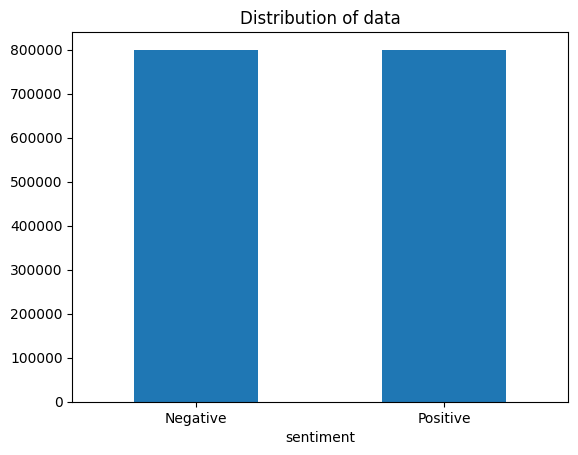

In [7]:
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

As we can see from the graphs, we have equal number of Positive/Negative tweets. Both equaling to 800,000 tweets. This means our dataset is **not skewed** which makes working on the dataset easier for us.

## <a id="3">Preprocessing the Text</a>
**Text Preprocessing** is traditionally an important step for **Natural Language Processing (NLP)** tasks. It transforms text into a more digestible form so that deep learning algorithms can perform better.

Tweets usually contains a lot of information apart from the text, like mentions, hashtags, urls, emojis or symbols. Since normally, NLP models cannot parse those data, we need to clean up the tweet and replace tokens that actually contains meaningful information for the model.

**The Preprocessing steps taken are:**
1. **Lower Casing:** Each text is converted to lowercase.
2. **Replacing URLs:** Links starting with **'http' or 'https' or 'www'** are replaced by **'<url\>'**.
3. **Replacing Usernames:** Replace @Usernames with word **'<user\>'**. [eg: '@Kaggle' to '<user\>'].
4. **Replacing Consecutive letters:** 3 or more consecutive letters are replaced by 2 letters. [eg: 'Heyyyy' to 'Heyy']
5. **Replacing Emojis:** Replace emojis by using a regex expression. [eg: ':)' to '<smile\>']
6. **Replacing Contractions:** Replacing contractions with their meanings. [eg: "can't" to 'can not']
7. **Removing Non-Alphabets:** Replacing characters except Digits, Alphabets and pre-defined Symbols with a space.

As much as the preprocessing steps are important, the actual sequence is also important while cleaning up the text. For example, removing the punctuations before replacing the urls means the regex expression cannot find the urls. Same with mentions or hashtags. So make sure, the actual sequence of cleaning makes sense.

In [8]:
# Reading contractions.csv and storing it as a dict.
contractions = pd.read_csv(ishivinal_contractions_path + '/contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)

    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

Cleaning up the tweet text and storing it in **"processed_text"** field in the dataframe.

In [9]:
%%time
dataset['processed_text'] = dataset.text.apply(preprocess_apply)

CPU times: user 1min 3s, sys: 224 ms, total: 1min 4s
Wall time: 1min 4s


Let's have a look and see what the processed text looks like.

In [10]:
count=0
for row in dataset.itertuples():
    print("Text:", row[2])
    print("Processed:", row[3])
    count+=1
    if count>10:
        break

Text: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Processed: <user> <url>   aww  thatis a bummer   you shoulda got david carr of third day to do it  <smile>
Text: is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
Processed: is upset that he cannot update his facebook by texting it   and might cry as a result  school today also  blah 
Text: @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
Processed: <user> i dived many times for the ball  managed to save 50   the rest go out of bounds
Text: my whole body feels itchy and like its on fire 
Processed: my whole body feels itchy and like its on fire 
Text: @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
Processed: <user> no  it is not behaving at all  i am mad  why am i here  because i cannot see you all ov

## <a id="4">Analysing the Data</a>
Now we're going to analyse the preprocessed data to get an understanding of it. We'll plot **Word Clouds** for **Positive and Negative** tweets from our dataset and see which words occur the most.

In [11]:
processedtext = list(dataset['processed_text'])
data_pos = processedtext[800000:]
data_neg = processedtext[:800000]

### Word-Cloud for Positive tweets.

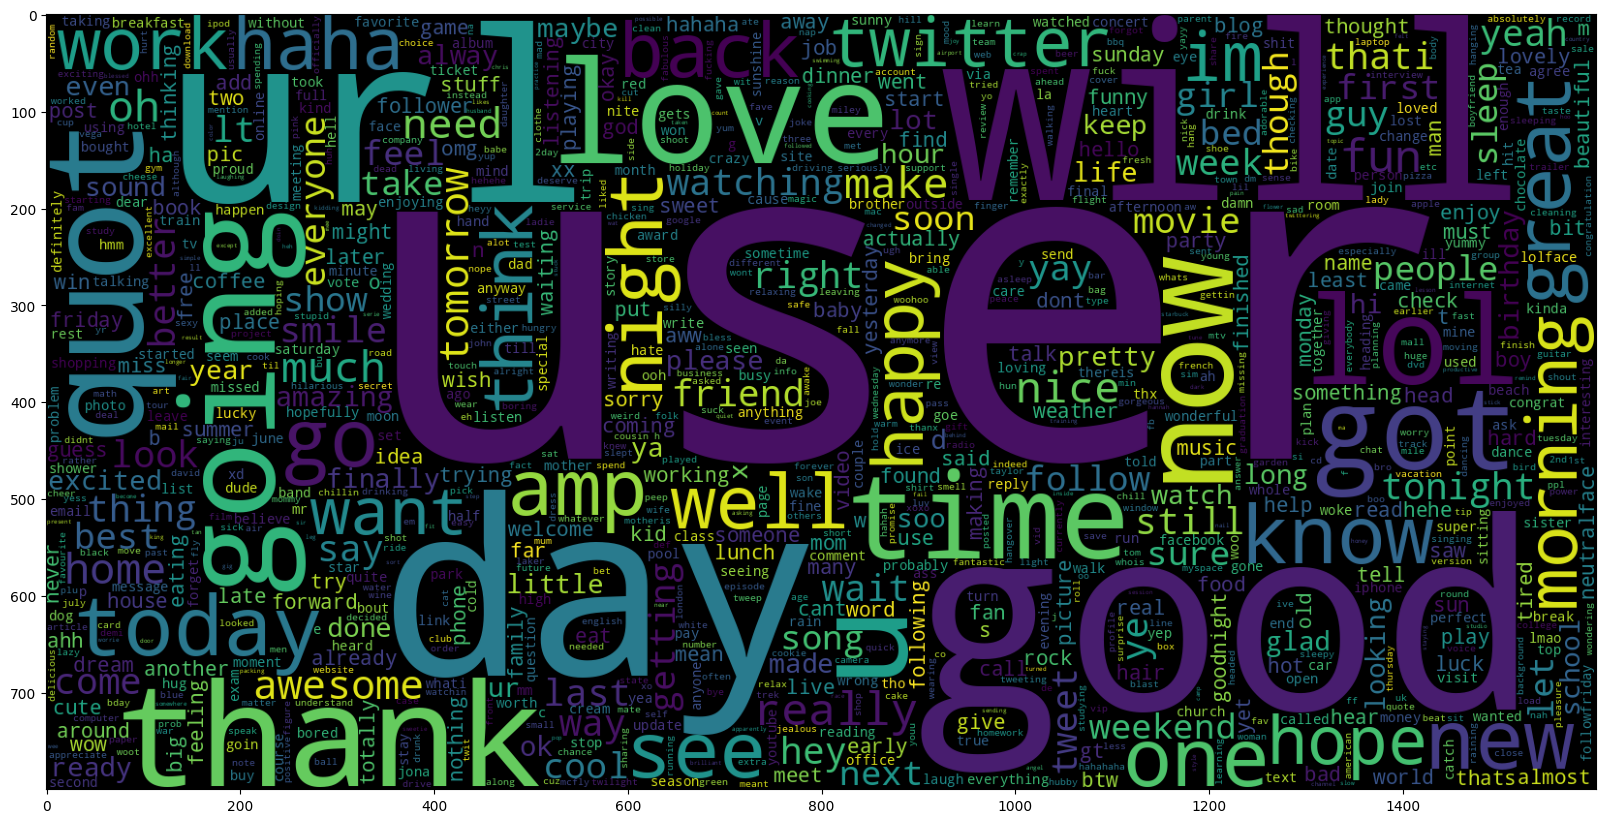

In [12]:
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

### Word-Cloud for Negative tweets.

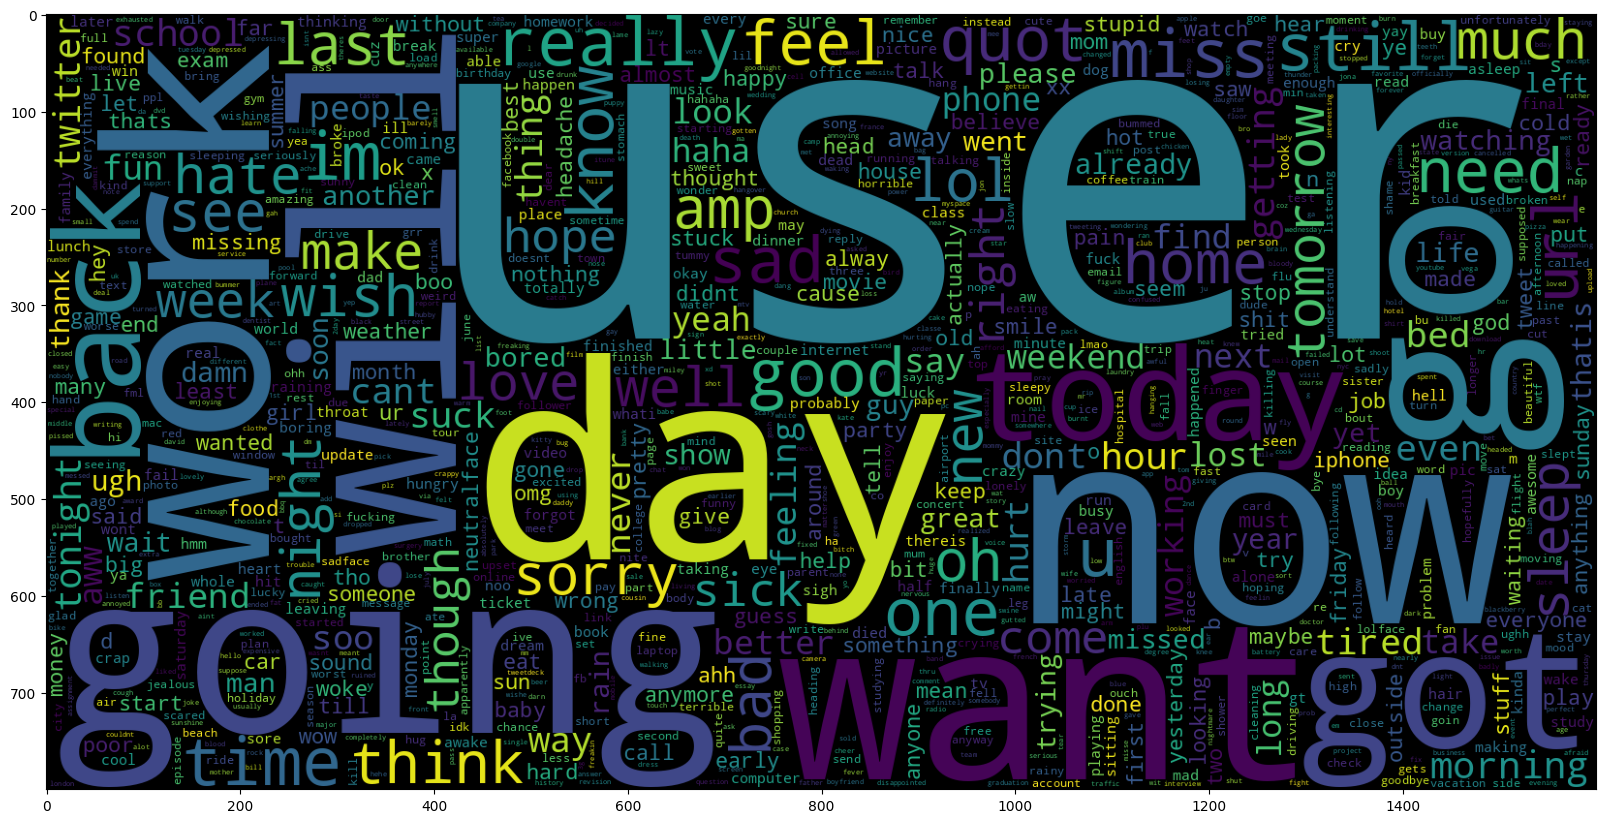

In [13]:
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.figure(figsize = (20,20))
plt.imshow(wc)

## <a id="5">Splitting the Data</a>

Machine Learning models are trained and tested on different sets of data. This is done so to reduce the chance of the model overfitting to the training data, i.e it fits well on the training dataset but a has poor fit with new ones.

**sklearn.model_selection.train_test_split** shuffles the dataset and splits it into train and test dataset.

The Pre-processed Data is divided into 2 sets of data:
1. **Training Data:** The dataset upon which the model would be trained on. Contains 95% data.
2. **Test Data:** The dataset upon which the model would be tested against. Contains 5% data.

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_data, y_data = np.array(dataset['processed_text']), np.array(dataset['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.05, random_state = 0)
print('Data Split done.')

Data Split done.


## <a id="6">Creating Word Embeddings using Word2Vec model</a>

**Word embedding** is one of the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc. Loosely speaking, word embeddings are **vector representations** of a particular word.

**Word2Vec** was developed by Google and is one of the most popular technique to learn word embeddings using shallow neural network.
Word2Vec can create word embeddings using two methods (both involving Neural Networks): **Skip Gram** and **Common Bag Of Words (CBOW)**.

To learn more about Word2Vec and Word embeddings check out this [article](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa).

In [16]:
!pip install gensim


In [17]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

**Word2Vec()** function creates and trains the word embeddings using the data passed.

**Training Parameters**
* **size:** The number of dimensions (N) that the Word2Vec maps the words onto. Bigger size values require more training data, but can lead to better (more accurate) models.
* **workers:** Specifies the number of worker threads for training parallelization, to speed up training.
* **min_count:** min_count is for pruning the internal dictionary. Words that appear only once or twice in a billion-word corpus are probably uninteresting typos and garbage. In addition, there’s not enough data to make any meaningful training on those words, so it’s best to ignore them.

In [18]:
%%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 52025
CPU times: user 3min 22s, sys: 1.15 s, total: 3min 23s
Wall time: 2min 6s


## <a id="7">Tokenizing and Padding datasets</a>

**Tokenization** is a common task in **Natural Language Processing (NLP)**. It’s a fundamental step in both traditional NLP methods like **Count Vectorizer** and Advanced Deep Learning-based architectures like **Transformers**.

**Tokenization** is a way of separating a piece of text into smaller units called **tokens**. Here, tokens can be either words, characters, or subwords. Hence, tokenization can be broadly classified into 3 types – word, character, and subword (n-gram characters) tokenization.

All the neural networks require to have inputs that have the same shape and size. However, when we pre-process and use the texts as inputs for our model e.g. LSTM, not all the sentences have the same length. We need to have the inputs with the same size, this is where the **padding** is necessary.

**Padding** is the process by which we can add padding tokens at the start or end of a sentence to increase it's length upto the required size. If required, we can also drop some words to reduce to the specified length.


* **Tokenizer:** Tokenizes the dataset into a list of tokens.
* **pad_sequences:** Pads the tokenized data to a certain length.

The **input_length** has been set to 60. This will be the length after the data is tokenized and padded.

In [19]:
# Defining the model input length.
input_length = 60

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Defining the **Tokenizer** and fitting it on the training data. Here, we are tokenzing the data by spliting it up with the **delimiter space ' '**.

**Args in Tokenizer():**
1. **filters:** Characters to filter out from the sentences to tokenize.
2. **lower:** True/False. Whether to lowerCase the sentence or not.
3. **oov_token:** Out of Vocabulary token to put in for words which aren't in the tokenizer vocab.

Filters and lower has been turned off because we've already done those steps during the preprocessing step.

In [20]:
vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 60000


Tokenizing the **X_train and X_test** dataset and padding them to the length **'input_length'**.

The tokenized list is **pre-padded**, i.e padding tokens are added to the start. After padding, the length of the data would be equal to **'input_length'**.

In [21]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (1520000, 60)
X_test.shape : (80000, 60)


## <a id="8">Creating Embedding Matrix</a>

**Embedding Matrix** is a maxtrix of all words and their corresponding embeddings. We use embedding matrix in an **Embedding layer** in our model to embedded a token into it's vector representation, that contains information regarding that token or word.

We get the embedding vocabulary from the tokenizer and the corresponding vectors from the Embedding Model, which in this case is the Word2Vec model.

**Shape of Embedding matrix** is usually the **Vocab Length * Embedding Dimension.**


In [22]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (60000, 100)


## <a id="9">Creating the Model</a>

There are different approches which we can use to build our Sentiment analysis model. We're going to build a deeplearning **Sequence model.**

**Sequence model** are very good at getting the context of a sentence, since it can understand the meaning rather than employ techniques like counting positive or negative words like in a **Bag-of-Words model**.

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

### Model Architecture

1) **Embedding Layer:** Layer responsible for converting the tokens into their vector representation that is generated by Word2Vec model. We're using the predefined layer from Tensorflow in out model.

**Arguments -**
* **input_dim**: Size of the vocabulary.
* **output_dim**: Dimension of the dense embedding.
* **weights**: Initiazises the embedding matrix.
* **trainable**: Specifies whether the layer is trainable or not.

2) **Bidirectional:** Bidirectional wrapper for RNNs. It means the context are carried from both left to right and right to left in the wrapped RNN layer.

3) **LSTM:** **Long Short Term Memory**, its a variant of **RNN** which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.

**Arguments -**
* **units:** Positive integer, dimensionality of the output space.
* **dropout:**  Fraction of the units to drop for the linear transformation of the inputs.
* **return_sequence:** Whether to return the last output in the output sequence, or the full sequence.

4) **Conv1D:** This layer creates a convolution kernel that is convolved with the layer input over a single dimension to produce a tensor of outputs.

**Arguments -**
* **filters:** The dimensionality of the output space (i.e. the number of output filters in the convolution).
* **kernel_size:** Specifies the length of the 1D convolution window.
* **activation:** Specifies the activation function to use.

5) **GlobalMaxPool1D:** Downsamples the input representation by taking the maximum value over the different dimensions.


6) **Dense:** Dense layer adds a fully connected layer in the model. The argument passed specifies the number of nodes in that layer.

The last dense layer has the activation **"Sigmoid"**, which is used to transform the input to a number between 0 and 1. Sigmoid activations are generally used when we have 2 categories to output in.

In [24]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

### Model Summary

In [25]:
training_model = getModel()
training_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "Sentiment_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,000,000 (22.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,000,000 (22.89 MB)

## <a id="10">Training the Model</a>

### Model Callbacks

**Callbacks** are objects that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

We can use callbacks to write **TensorBoard logs** after every batch of training, periodically save our model, stop training early or even to get a view on internal states and statistics during training.

**ReduceLROnPlateau:** Reduces Learning Rate whenever the gain in performance metric specified stops improving.

* monitor: quantity to be monitored.
* patience: number of epochs with no improvement after which learning rate will be reduced.
* cooldown: number of epochs to wait before resuming normal operation after lr has been reduced.

**EarlyStopping:** Stop training when a monitored metric has stopped improving.

* monitor: Quantity to be monitored.
* min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
* patience: Number of epochs with no improvement after which training will be stopped.

For more details on callbacks, check out the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback) on tensorflow.

In [26]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

### Model Compile

The Model must be compiled to define the **loss, metrics and optimizer**. Defining the proper loss and metric is essential while training the model.

**Loss:** We're using **Binary Crossentropy**. It is used when we have binary output categories. Check out this article on [losses](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/).

**Metric:** We've selected **Accuracy** as it is one of the common evaluation metrics in classification problems when the category data is equal. Learn more about metrics [here](https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/).

**Optimizer:** We're using **Adam**, optimization algorithm for Gradient Descent. You can learn more about Adam [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam).

In [27]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

We'll now train our model using the **fit** method and store the output learning parameters in **history**, which can be used to plot out the learning curve.

**Arguements:**
* **batch_size:** Number of samples per gradient update. Increasing the batch_size speeds up the training.
* **epochs:** Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided.
* **validation_split:** Float between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch
* **callbacks:** List of callbacks to apply during training process.
* **verbose:** 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.

In [28]:
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=12,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/12
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 177s 126ms/step - accuracy: 0.7734 - loss: 0.4682 - val_accuracy: 0.8109 - val_loss: 0.4121 - learning_rate: 0.0010
Epoch 2/12
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 202s 128ms/step - accuracy: 0.8146 - loss: 0.4028 - val_accuracy: 0.8191 - val_loss: 0.3968 - learning_rate: 0.0010
Epoch 3/12
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 202s 128ms/step - accuracy: 0.8224 - loss: 0.3895 - val_accuracy: 0.8245 - val_loss: 0.3883 - learning_rate: 0.0010
Epoch 4/12
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 202s 128ms/step - accuracy: 0.8271 - loss: 0.3812 - val_accuracy: 0.8269 - val_loss: 0.3825 - learning_rate: 0.0010
Epoch 5/12
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 199s 126ms/step - accuracy: 0.8300 - loss: 0.3759 - val_accuracy: 0.8282 - val_loss: 0.3803 - learning_rate: 0.0010
Epoch 6/12
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 205s 128ms/step - accuracy: 0.8327 - loss: 0.3707 - val_accuracy: 0.8301 - val_loss: 0.3760 - learning_rate: 0.0010
Epoch 7/12
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 202s 128ms

## <a id="11">Evaluating Model</a>

Since our dataset is not **skewed**, i.e. it has equal number of **Positive and Negative Predictions**. We're choosing **Accuracy** as our evaluation metric. Furthermore, we're plotting the **Confusion Matrix** to get an understanding of how our model is performing on both classification types.

### Printing out the Learning curve

Learning curves show the relationship between training set size and your chosen evaluation metric (e.g. RMSE, accuracy, etc.) on your training and validation sets. They can be an extremely useful tool when diagnosing your model performance, as they can tell you whether your model is suffering from bias or variance.

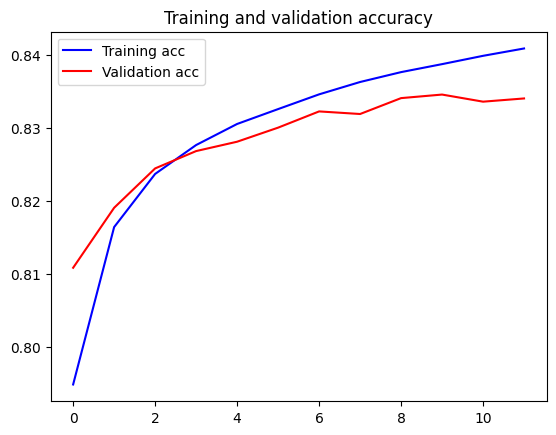

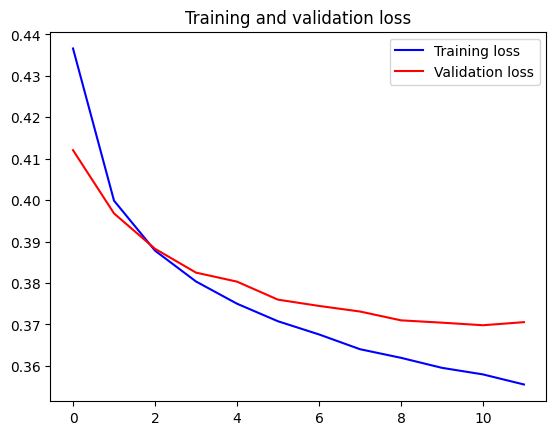

In [29]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

From the training curve we can conclude that our model doesn't have bias nor is it overfitting. The accuracy curve has flattened but is still rising, which means training for more epochs can yield better results.

The Validation loss is lower than the training loss because the dropouts in LSTM aren't active while evaluating the model.

### Confusion Matrix

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step


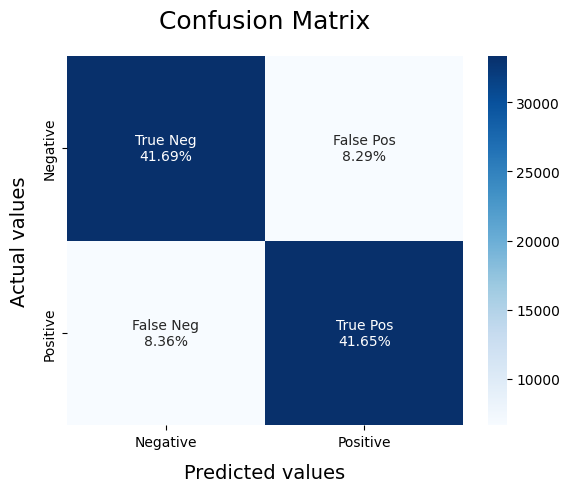

In [31]:
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics.
ConfusionMatrix(y_pred, y_test)

From the confusion matrix, it can be concluded that the model makes more False Negative predictions than positive. This means that the model is **somewhat biased** towards predicting negative sentiment.

### Classification Report

In [32]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83     39989
           1       0.83      0.83      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



Using the classification report, we can see that that the model achieves nearly **85% Accuracy** after training for just **12 epochs.** This is really good and better than most other models achieve.

## <a id="12">Saving the Model</a>

We're saving the **tokenizer, Word2Vec and Tensorflow model** for use later.

**Word2Vec model** has been saved as 2 different formats:
1. **KeyedVectors:** KeyedVectors do not support further training. On the other hand, by shedding the internal data structures necessary for training, KeyedVectors offer a smaller RAM footprint and a simpler interface.
2. **Full Word2Vec Model:** The Full Word2Vec model contains the model state to enable further training. Saving in this format enables us to update the Vectors later.

In [36]:
# Saving Word2Vec-Model
word2vec_model.wv.save('Word2Vec-twitter-100')
word2vec_model.wv.save_word2vec_format('Word2Vec-twitter-100-trainable')

# Saving the tokenizer
with open('Tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)

# Saving the TF-Model.
training_model.save('Sentiment-BiLSTM.h5')
training_model.save_weights("Model-Weights.weights.h5")

In [37]:
!ls -al

total 152976
drwxr-xr-x 1 root root     4096 Jun 22 10:54 .
drwxr-xr-x 1 root root     4096 Jun 22 09:14 ..
drwxr-xr-x 4 root root     4096 Jun 18 13:35 .config
-rw-r--r-- 1 root root 30098192 Jun 22 10:54 Model-Weights.weights.h5
drwxr-xr-x 1 root root     4096 Jun 18 13:35 sample_data
-rw-r--r-- 1 root root 30113928 Jun 22 10:54 Sentiment-BiLSTM.h5
-rw-r--r-- 1 root root 12282408 Jun 22 10:54 Tokenizer.pickle
-rw-r--r-- 1 root root 22343383 Jun 22 10:54 Word2Vec-twitter-100
-rw-r--r-- 1 root root 61768238 Jun 22 10:54 Word2Vec-twitter-100-trainable


In [38]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [46]:
!mkdir /content/drive/MyDrive/Labs

mkdir: cannot create directory ‘/content/drive/MyDrive/Labs’: File exists


In [52]:
!mkdir drive/MyDrive/Labs/NLP

In [56]:
!cp -r Word2Vec-twitter-100 drive/MyDrive/Labs/NLP
!cp -r Word2Vec-twitter-100-trainable drive/MyDrive/Labs/NLP
!cp -r Tokenizer.pickle drive/MyDrive/Labs/NLP
!cp -r Sentiment-BiLSTM.h5 drive/MyDrive/Labs/NLP
!cp -r Model-Weights.weights.h5 drive/MyDrive/Labs/NLP